In [76]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

# gdf = gpd.GeoDataFrame(df[['DateTime', 'Longitude', 'Latitude']], 
#                        geometry=gpd.points_from_xy(df.Longitude, df.Latitude), 
#                        crs="EPSG:4326")

In [69]:
df = pd.read_csv('..\\data\\TestDriveNoise_8May2024.csv')
measurements = list(zip(df['Latitude'], df['Longitude']))

window_size = 20
min_i = lambda i: max(0, i-(window_size//2))
max_i = lambda i: min(df.shape[0], i+(window_size//2))
zscore_long_windowed = [scipy.stats.zscore(df['Longitude'][min_i(i):max_i(i)], nan_policy='raise')[i]
                        for i in range(df.shape[0])]
zscore_lat_windowed = [scipy.stats.zscore(df['Latitude'][min_i(i):max_i(i)])[i]
                        for i in range(df.shape[0])]

print(f'value must be zero: {df.isna().sum().sum()}')
df['lat_z'] = zscore_lat_windowed
df['long_z'] = zscore_long_windowed
df.fillna(0, inplace=True)
print(df.isna().sum().sum(), df.shape)

value must be zero: 0
0 (13519, 8)


In [80]:
tdf = df[(df['lat_z'] < 0.8) & (df['long_z'] < 0.8)]
gdf = gpd.GeoDataFrame(tdf[['DateTime', 'Longitude', 'Latitude']], 
                       geometry=gpd.points_from_xy(tdf.Longitude, tdf.Latitude), 
                       crs="EPSG:4326")
print(gdf.shape)

(12096, 4)


<GeoAxes: >

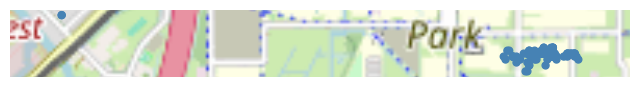

In [81]:
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf[:180], ax=ax)

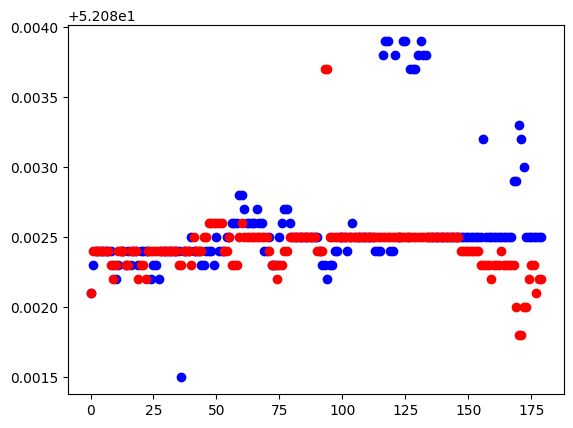

In [82]:
plt.figure(1)
og_measurements = list(zip(df['Latitude'], df['Longitude']))
measurements = list(zip(tdf['Latitude'], tdf['Longitude']))
measurements_plot = np.asarray(measurements)
og_plot = np.asarray(og_measurements)
start, end = 0,180
plt.plot(range(end-start), og_plot[start:end, 0], 'bo')
plt.plot(range(end-start), measurements_plot[start:end, 0], 'ro')
plt.show()


In [67]:
gdf.shape

(10422, 4)

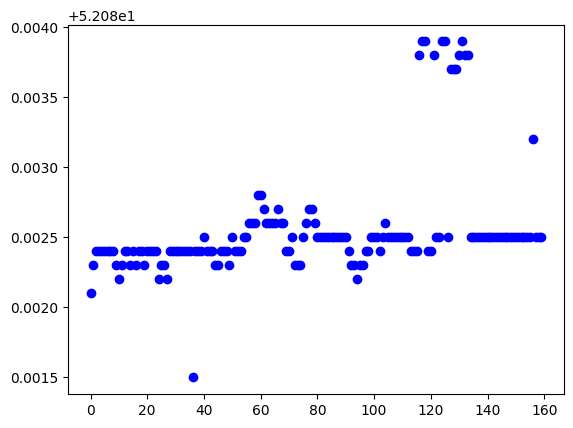

In [109]:
plt.figure(1)
measurements_plot = np.asarray(measurements)
start, end = 0,160
plt.plot(range(end-start), measurements_plot[start:end, 0], 'bo')
plt.show()

In [110]:
df['Latitude'] = df['Latitude'].rolling(5, center=True, min_periods=1).median()
df['Longitude'] = df['Longitude'].rolling(5, center=True, min_periods=1).median()
measurements = list(zip(df['Latitude'], df['Longitude']))

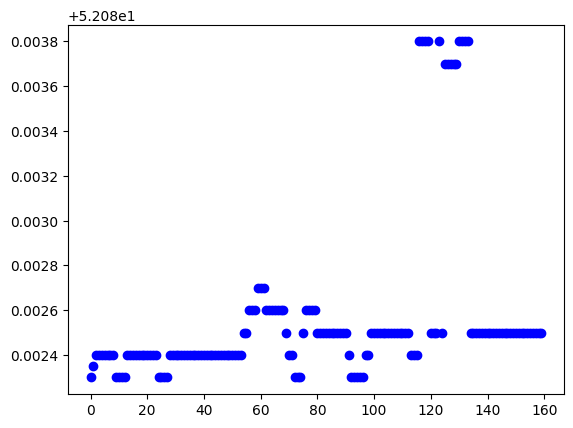

In [111]:
import matplotlib.pyplot as plt
plt.figure(1)
measurements_plot = np.asarray(measurements)
start, end = 0,160
plt.plot(range(end-start), measurements_plot[start:end, 0], 'bo')
plt.show()

In [83]:
from pykalman import KalmanFilter
from pykalman import AdditiveUnscentedKalmanFilter

measurements = list(zip(gdf['Latitude'], gdf['Longitude']))

initial_state_mean = [measurements[0][0], 0,
                      measurements[0][1], 0]
transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]
observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  )
kf = kf.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [97]:
kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 1000*kf.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

kf2 = kf2.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances)  = kf2.smooth(measurements)

In [98]:
lats, _, longs, _ = list(zip(*smoothed_state_means))
df['Latitude'] = lats
df['Longitude'] = longs

gdf = gpd.GeoDataFrame(df[['DateTime', 'Longitude', 'Latitude']], 
                       geometry=gpd.points_from_xy(df.Longitude, df.Latitude), 
                       crs="EPSG:4326")
print(lats[:5])
print(longs[:5])

(52.08210647242846, 52.082127881043704, 52.08216004242225, 52.08219554120463, 52.08223006879232)
(5.180965785809456, 5.1811703604440025, 5.181453506539077, 5.181773352241736, 5.182095242476989)


<GeoAxes: >

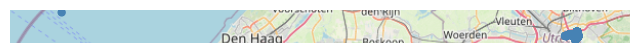

In [8]:
import geoplot as gplt
import geoplot.crs as gcrs
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf[:4000], ax=ax)

<GeoAxes: >

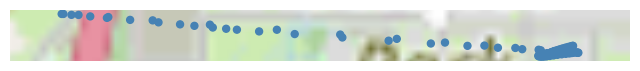

In [101]:
gdf = gdf[gdf['Longitude'] > 5]
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf[60:150], ax=ax)

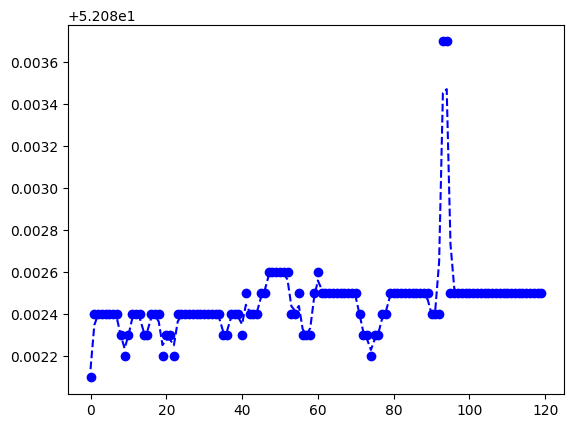

In [84]:
import matplotlib.pyplot as plt
plt.figure(1)
measurements_plot = np.asarray(measurements)
times = range(len(measurements_plot[:120]))
plt.plot(times, measurements_plot[0:120, 0], 'bo',
        #  times, measurements_plot[:, 1], 'ro',
         times, smoothed_state_means[0:120, 0], 'b--',
        #  times, smoothed_state_means[:, 2], 'r--',)
)
plt.show()

In [103]:
kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
       
kf2 = kf2.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances)  = kf2.smooth(measurements)

SyntaxError: '(' was never closed (861402315.py, line 1)

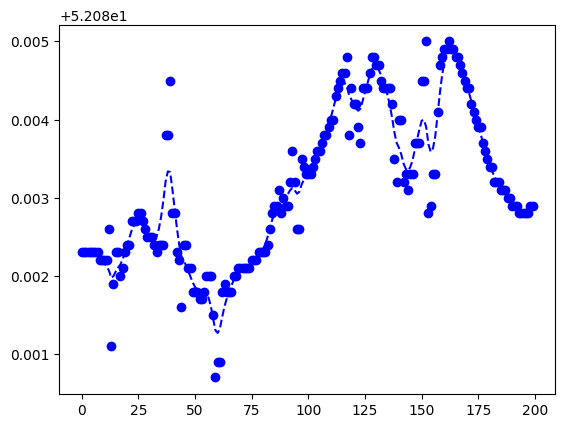

In [ ]:
plt.figure(2)
times = range(200)
plt.plot(times, measurements_plot[2900:3100, 0], 'bo',
        #  times, measurements_plot[:120, 1], 'ro',
         times, smoothed_state_means[2900:3100, 0], 'b--',
        #  times, smoothed_state_means[:, 2], 'r--',)
)
plt.show()

In [ ]:
gdf[90:150]

,DateTime,Longitude,Latitude,geometry
95,2024-05-08 07:15:42,5.18105,52.08235,POINT (5.18105 52.08235)
96,2024-05-08 07:15:43,5.18115,52.08235,POINT (5.18115 52.08235)
97,2024-05-08 07:15:44,5.18125,52.08235,POINT (5.18125 52.08235)
98,2024-05-08 07:15:45,5.18135,52.08240,POINT (5.18135 52.08240)
99,2024-05-08 07:15:46,5.18140,52.08240,POINT (5.18140 52.08240)
100,2024-05-08 07:15:47,5.18140,52.08245,POINT (5.18140 52.08245)
101,2024-05-08 07:15:48,5.18165,52.08250,POINT (5.18165 52.08250)
102,2024-05-08 07:15:49,5.18190,52.08250,POINT (5.18190 52.08250)
103,2024-05-08 07:15:50,5.18190,52.08250,POINT (5.18190 52.08250)
104,2024-05-08 07:15:51,5.18190,52.08250,POINT (5.18190 52.08250)


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

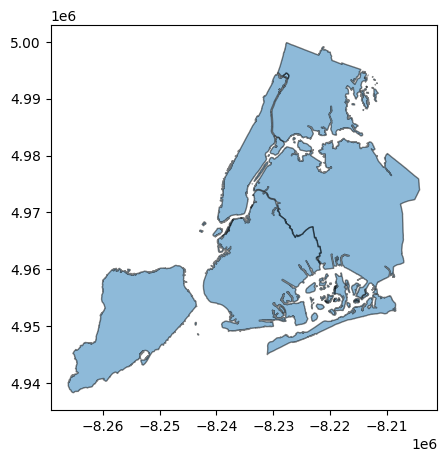

In [ ]:
import geodatasets
df = gpd.read_file(geodatasets.get_path("nybb"))
df = df.to_crs(epsg=3857)
ax = df.plot(figsize=(5,5), alpha=0.5, edgecolor="k")
cx.add_basemap(ax)